In [14]:
import pandas as pd

# path = "/home/kyle/data/polygon_cache/data/A/AMZE/trades/5minute/202503.parquet"
path = "/mnt/nas/price_data/polygon/data/A/ACIW/trades/5minute/202101.parquet"
# path = "/mnt/nas/price_data/polygon/data/Z/ZUMZ/trades/5minute/202507.parquet"
# path="/mnt/nas/price_data/polygon/data/A/AAIC/trades/5minute/202312.parquet"

df = pd.read_parquet(path)
print(df.dtypes)
# data[data.index.duplicated(keep=False)]

ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet file size is 0 bytes

In [1]:
import matplotlib.pyplot as plt
from data_manager import DataManager
from pathlib import Path
from datetime import datetime, time
from zoneinfo import ZoneInfo
import pandas as pd

# --- Configuration ---
# BASE_DATA_DIR = Path("/mnt/nas/price_data/polygon")
BASE_DATA_DIR = Path("/home/kyle/data/polygon_cache")
SYMBOL = "AMZE"
FREQUENCY = "5minute"

# --- Data Loading ---
datamanager = DataManager(BASE_DATA_DIR)
print(f"Loading data for {SYMBOL}...")
data = datamanager.get_data(
    symbol=SYMBOL,
    freq=FREQUENCY,
    enriched=False,
    # start=datetime(2025, 5, 14),
    # end=datetime(2022, 2, 20)
)

duplicates = data[data.index.duplicated(keep=False)]


# --- Plotting ---
if not data.empty:
    print("Data loaded. Generating plot...")
    # Use fig, ax for more control over the plot
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # Plot the main price data
    ax.plot(data.index, data['vwap'], label=f'{SYMBOL} VWAP', color='royalblue', linewidth=2)

    # --- Add Vertical Lines for Market Hours ---
    # Get the unique days present in the data's index
    # The index is already UTC, so we normalize to get the day part
    unique_days = data.index.normalize().unique()

    # Define market hours in the US/Eastern timezone
    market_open_time = time(9, 30)
    market_close_time = time(16, 0)
    et_zone = ZoneInfo("America/New_York")

    # For each day in our data, draw the open/close lines
    for day in unique_days:
        # Create timezone-aware datetime objects for open and close in ET
        market_open_dt_et = datetime.combine(day.date(), market_open_time, tzinfo=et_zone)
        market_close_dt_et = datetime.combine(day.date(), market_close_time, tzinfo=et_zone)

        # Matplotlib will automatically handle plotting these on the UTC-based axis
        ax.axvline(market_open_dt_et, color='green', linestyle='--', linewidth=1.2, alpha=0.8, label='Market Open (9:30 ET)' if day == unique_days[0] else "")
        ax.axvline(market_close_dt_et, color='red', linestyle='--', linewidth=1.2, alpha=0.8, label='Market Close (4:00 ET)' if day == unique_days[0] else "")

    # --- Formatting ---
    ax.set_title(f'{SYMBOL} {FREQUENCY} VWAP with Market Hours', fontsize=16)
    ax.set_xlabel('Date (UTC)', fontsize=12)
    ax.set_ylabel('VWAP', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Handle the legend to ensure labels for vertical lines only appear once
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()
    print("Plot displayed.")

else:
    print(f"No data found for {SYMBOL} in the specified date range.")



2025-07-17 10:12:48 - data_manager - INFO - DataManager initialized. Base directory: /home/kyle/data/polygon_cache
2025-07-17 10:12:48 - file_io - ERROR - Error reading data from pyarrow dataset for /home/kyle/data/polygon_cache/data/A/AMZE/trades/5minute: Float value 85.434800 was truncated converting to int64
Traceback (most recent call last):
  File "/home/kyle/projects/sctrading/raw_data/file_io.py", line 179, in read_raw_data
    table = dataset.to_table(filter=filter_expression)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pyarrow/_dataset.pyx", line 574, in pyarrow._dataset.Dataset.to_table
  File "pyarrow/_dataset.pyx", line 3865, in pyarrow._dataset.Scanner.to_table
  File "pyarrow/error.pxi", line 155, in pyarrow.lib.pyarrow_internal_check_status
  File "pyarrow/error.pxi", line 92, in pyarrow.lib.check_status
pyarrow.lib.ArrowInvalid: Float value 85.434800 was truncated converting to int64


Loading data for AMZE...
No data found for AMZE in the specified date range.


In [ ]:
import pandas as pd

BASE_DATA_DIR = Path("/mnt/nas/price_data/polygon")
pd.read_parquet(BASE_DATA_DIR / "AAPL" / "5minute" / "trade.parquet")

NameError: name 'BASE_DATA_DIR' is not defined

Successfully loaded and processed 2274 log entries.

--- Epoch Summary with Learning Rate ---
Empty DataFrame
Columns: [epoch, cumulative_batch, avg_epoch_train_loss, validation_loss, learning_rate]
Index: []


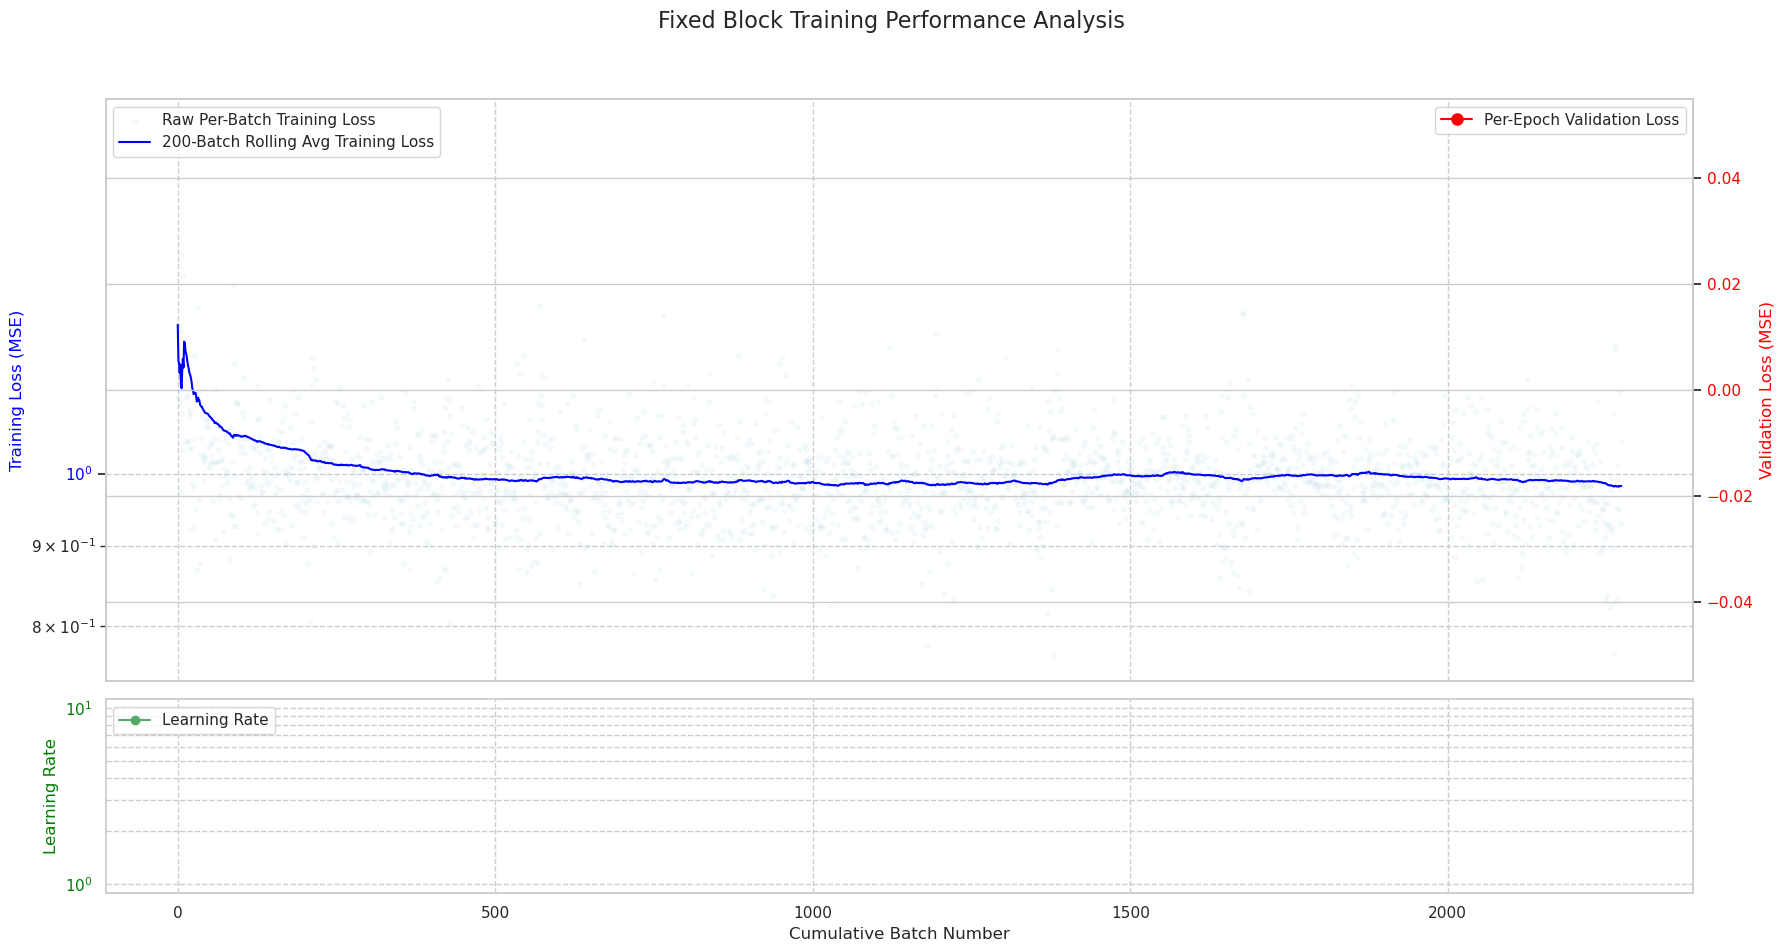

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# --- Configuration ---
# Set the path to the directory where your model and logs are saved.
MODELS_DIR = Path("/home/kyle/data/polygon_cache/models")
LOG_FILE_PATH = MODELS_DIR / "fixed_training_log.csv"

# --- Plotting Style ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (18, 10) # Adjusted for two subplots

# --- Load and Process Data ---
try:
    # Load the training log into a pandas DataFrame
    log_df = pd.read_csv(LOG_FILE_PATH)

    # --- FIXED: Create a cumulative batch counter for a continuous x-axis ---
    # This makes the plot correct even with multiple epochs.
    # Start with a 0-indexed batch count within each epoch
    log_df['cumulative_batch'] = log_df.groupby('epoch').cumcount()

    # Calculate the total number of batches in each preceding epoch
    # Assuming 'batch' column is 1-indexed and max('batch') gives the count for that epoch.
    # If 'batch' is 0-indexed, use (log_df.groupby('epoch')['batch'].max() + 1)
    batches_per_epoch = log_df.groupby('epoch')['batch'].max()

    # Add the cumulative sum of batches from previous epochs to the current epoch's batches
    for epoch_num in batches_per_epoch.index:
        if epoch_num > 1:
            # Sum of batches from all epochs prior to the current one
            prev_epochs_total_batches = batches_per_epoch.loc[:epoch_num-1].sum()
            log_df.loc[log_df['epoch'] == epoch_num, 'cumulative_batch'] += prev_epochs_total_batches

    # Extract epoch-level summary data for plotting validation loss and learning rate
    # Filter for rows where validation_loss is not NaN, and ensure 'learning_rate' is also present.
    # We want to use the 'cumulative_batch' from the full log_df for alignment.
    epoch_summary = log_df.dropna(subset=['validation_loss', 'learning_rate']).copy()
    
    # Ensure cumulative_batch is correctly aligned for epoch_summary
    # This was already handled by the initial cumulative_batch calculation on log_df
    # and then dropping NaNs. No further action needed here.

    print(f"Successfully loaded and processed {len(log_df)} log entries.")
    print("\n--- Epoch Summary with Learning Rate ---")
    print(epoch_summary[['epoch', 'cumulative_batch', 'avg_epoch_train_loss', 'validation_loss', 'learning_rate']])

    # --- Plotting ---
    fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle('Fixed Block Training Performance Analysis', fontsize=16)

    # Plot 1: Training and Validation Loss
    # Plot per-batch training loss (raw data)
    ax1.scatter(log_df['cumulative_batch'], log_df['raw_loss'], label='Raw Per-Batch Training Loss', color='lightblue', alpha=0.1, s=10)
    
    # Plot rolling average of training loss
    rolling_window = 200
    ax1.plot(log_df['cumulative_batch'], log_df['raw_loss'].rolling(window=rolling_window, min_periods=1).mean(), 
             label=f'{rolling_window}-Batch Rolling Avg Training Loss', color='blue')
    
    ax1.set_ylabel('Training Loss (MSE)', color='blue')
    ax1.set_yscale('log')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')
    ax1.grid(True, which="both", ls="--")

    # Create a second y-axis for validation loss on the first subplot
    ax2 = ax1.twinx()
    ax2.plot(epoch_summary['cumulative_batch'], epoch_summary['validation_loss'], 'o-', label='Per-Epoch Validation Loss', color='red', markersize=8)
    ax2.set_ylabel('Validation Loss (MSE)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='upper right')

    # Plot 2: Learning Rate
    ax3.plot(epoch_summary['cumulative_batch'], epoch_summary['learning_rate'], 'g-o', label='Learning Rate', markersize=6)
    ax3.set_xlabel('Cumulative Batch Number')
    ax3.set_ylabel('Learning Rate', color='green')
    ax3.set_yscale('log') # Learning rates often change multiplicatively, so log scale is good
    ax3.tick_params(axis='y', labelcolor='green')
    ax3.legend(loc='upper left')
    ax3.grid(True, which="both", ls="--")


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except FileNotFoundError:
    print(f"ERROR: Log file not found at {LOG_FILE_PATH}")
    print("Please ensure the path is correct and the training script has been run.")
except Exception as e:
    print(f"An error occurred: {e}")


Loading enriched data for AAIC...
Data loaded successfully.
Selecting data from the last 30 days for plotting...
Generating plot...


/tmp/ipykernel_1291588/3786405144.py:29: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  plot_data = enriched_data.last('30D')


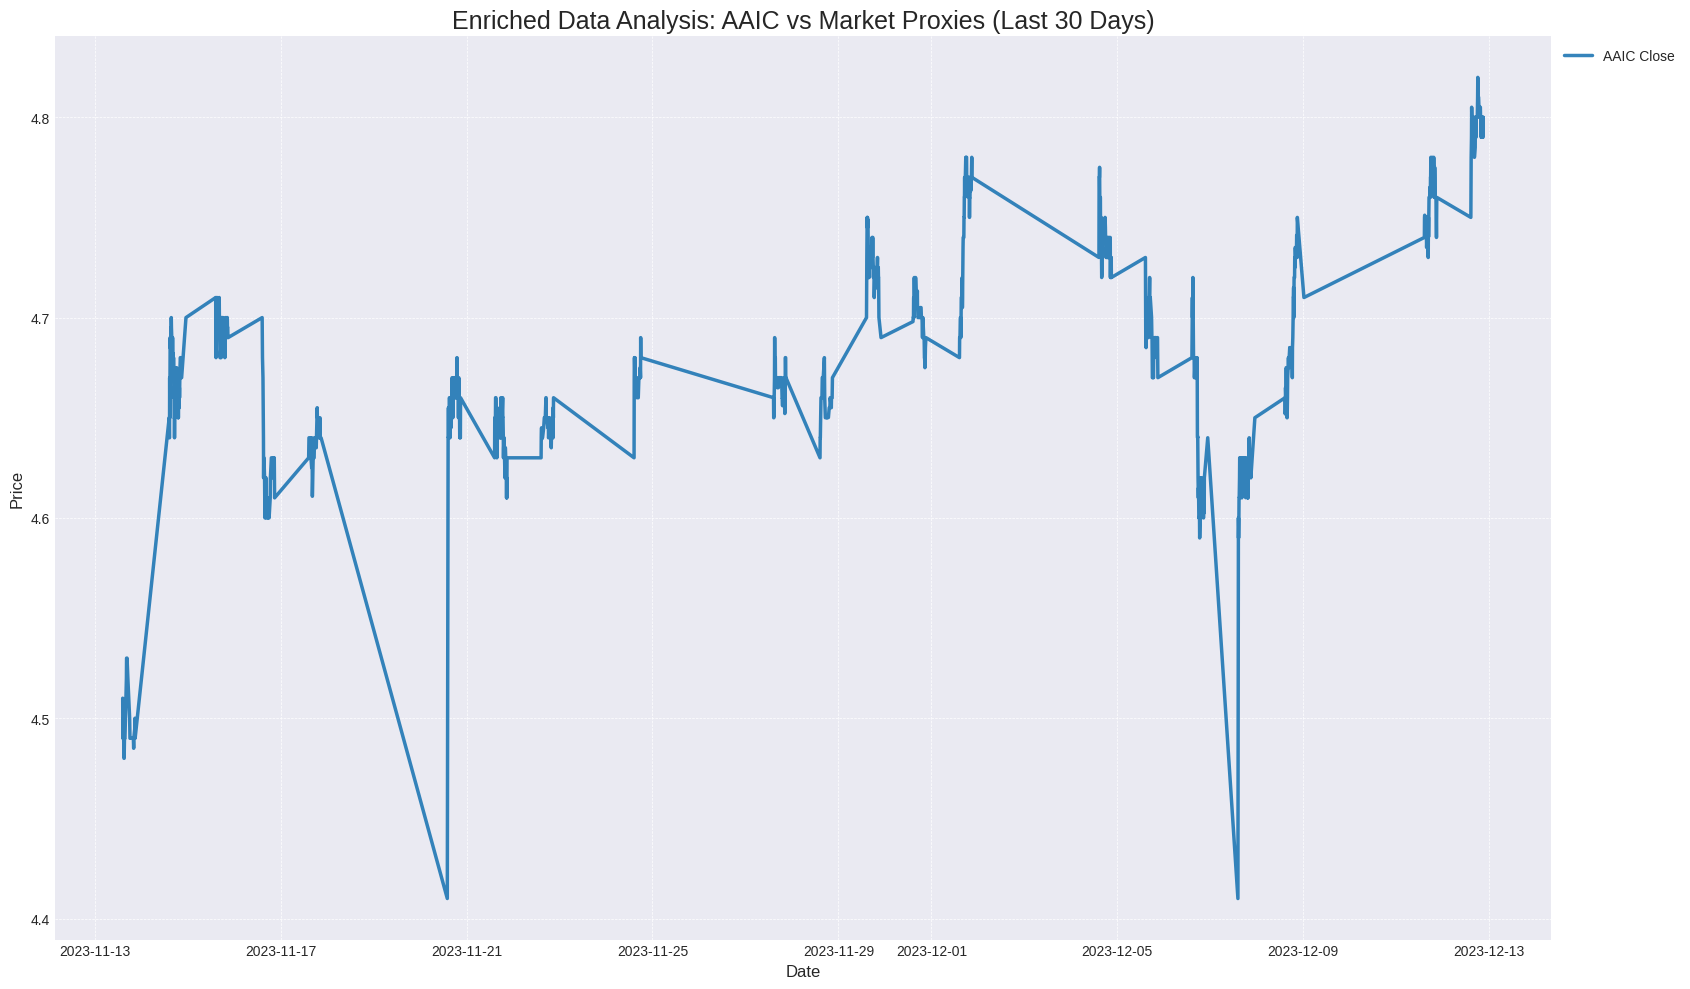

Plot displayed.


In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from data_manager import DataManager
from pathlib import Path
import pandas as pd

# --- Configuration ---
# Use the local cache directory where the enriched file was saved
BASE_DATA_DIR = Path("/home/kyle/data/polygon_cache")
SYMBOL = "AAIC"

# --- Load Data ---
datamanager = DataManager(BASE_DATA_DIR)

print(f"Loading enriched data for {SYMBOL}...")
# Load the ENRICHED data file for the symbol
# This contains the pre-calculated features for AAIC, SPY, and VXX
enriched_data = datamanager.get_data(
    symbol=SYMBOL,
    enriched=True # This is the key to loading the correct file
)
print("Data loaded successfully.")

# --- Plotting ---
if not enriched_data.empty:
    # Let's select a smaller time slice for better visualization, e.g., one month
    # This is optional but highly recommended for intraday data
    print("Selecting data from the last 30 days for plotting...")
    plot_data = enriched_data.last('30D')

    if plot_data.empty:
        print("No data in the last 30 days to plot. Using the full dataset instead.")
        plot_data = enriched_data

    print("Generating plot...")
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(20, 10))

    # --- Define Colors & Styles ---
    colors = mcolors.TABLEAU_COLORS
    aaic_color = colors['tab:blue']
    spy_color = colors['tab:green']
    vxx_color = colors['tab:red']
    
    # --- Plot Main Prices ---
    ax.plot(plot_data.index, plot_data['close'], label=f'{SYMBOL} Close', color=aaic_color, linewidth=2.5, zorder=10, alpha=0.9)
    # ax.plot(plot_data.index, plot_data['spy_close'], label='SPY Close', color=spy_color, linewidth=1.5, zorder=9, alpha=0.8)
    # ax.plot(plot_data.index, plot_data['vxx_close'], label='VXX Close', color=vxx_color, linewidth=1.5, zorder=8, alpha=0.8)

    # --- Plot Trendlines (EWMAs) ---
    ewma_periods = [8, 16, 32, 64, 128, 200]
    for period in ewma_periods:
        # AAIC EWMAs
        aaic_ewma_col = f'AAIC_ewma_{period}'
        if aaic_ewma_col in plot_data.columns:
            ax.plot(plot_data.index, plot_data[aaic_ewma_col], color=aaic_color, linestyle='--', alpha=0.7)
        
        # SPY EWMAs
        spy_ewma_col = f'SPY_ewma_{period}'
        if spy_ewma_col in plot_data.columns:
            ax.plot(plot_data.index, plot_data[spy_ewma_col], color=spy_color, linestyle=':', alpha=0.6)

        # VXX EWMAs
        vxx_ewma_col = f'VXX_ewma_{period}'
        if vxx_ewma_col in plot_data.columns:
            ax.plot(plot_data.index, plot_data[vxx_ewma_col], color=vxx_color, linestyle=':', alpha=0.6)

    # --- Formatting ---
    ax.set_title(f'Enriched Data Analysis: {SYMBOL} vs Market Proxies (Last 30 Days)', fontsize=18)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Create a clean legend outside the plot area
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend
    plt.show()
    print("Plot displayed.")

else:
    print(f"Could not load enriched data for {SYMBOL}. Please ensure the feature_precalculator.py script has been run successfully for this ticker.")


In [3]:
import matplotlib.pyplot as plt
from data_manager import DataManager
from pretraining_dataset_builder import PretrainingDatasetBuilder # Assuming this is in the same directory or path
from pathlib import Path
from datetime import datetime, date
import pandas as pd
import numpy as np

# --- Configuration ---
BASE_DATA_DIR = Path("/home/kyle/data/polygon_cache")
SYMBOL = "AAIC"
WINDOW_SIZE = 512 # This must match the builder's window size
NUM_FEATURES = 32 # This must match the builder's feature count

# --- 1. Instantiate the Builder and Load a Chunk of Data ---
datamanager = DataManager(BASE_DATA_DIR)
universe_path = datamanager.get_universe_path()

print("Initializing PretrainingDatasetBuilder...")
builder = PretrainingDatasetBuilder(
    data_manager_instance=datamanager,
    universe_file_path=universe_path,
    window_size=WINDOW_SIZE,
    num_features=NUM_FEATURES
)

# Load a chunk of data around a specific date for AAIC
# --- FIX: Expand the date range to load enough data ---
# The previous range was too short. We now load a larger chunk to ensure
# we have enough data for the window_size (512) plus the buffer days.
chunk_start = date(2022, 2, 1)
chunk_end = date(2022, 2, 28)
print(f"Loading data chunk for {SYMBOL} from {chunk_start} to {chunk_end}...")
data_cache = builder.load_data_for_chunk(chunk_start, chunk_end, debug_ticker=SYMBOL)

# --- 2. Generate a Single Sample ---
print("Generating one training sample...")
sample_generator = builder.generate_samples_from_cache(
    data_cache=data_cache,
    chunk_start_date=chunk_start,
    chunk_end_date=chunk_end,
    debug_ticker=SYMBOL
)

# Get the first available sample
try:
    features, targets, context = next(sample_generator)
    print(f"Successfully generated one sample for {context['symbol']} ending at {context['timestamp']}")
except StopIteration:
    print("Could not generate a sample. The data chunk might be too small or empty.")
    features, context = None, None

# --- 3. Prepare Log-Normalized Data for Plotting ---
if features is not None:
    print("Preparing log-normalized feature tensor for visualization...")
    
    # Find the original data window corresponding to the sample to get the index
    end_timestamp = pd.Timestamp(context['timestamp'])
    original_window_data = data_cache[SYMBOL].loc[:end_timestamp].tail(WINDOW_SIZE)
    
    # Create a new DataFrame to hold the log-normalized data
    plot_df = pd.DataFrame(index=original_window_data.index)
    
    # The feature is (price / last_price). We plot log(price / last_price).
    # This centers the plot around 0.
    
    # Main Symbol (AAIC)
    plot_df['AAIC_Close_Log'] = np.log(features[:, 3])
    plot_df['AAIC_EWMA_32_Log'] = np.log(features[:, 5])
    plot_df['AAIC_EWMA_200_Log'] = np.log(features[:, 6])
    
    # SPY
    plot_df['SPY_Close_Log'] = np.log(features[:, 10])
    plot_df['SPY_EWMA_32_Log'] = np.log(features[:, 12])
    plot_df['SPY_EWMA_200_Log'] = np.log(features[:, 13])

    # VXX
    plot_df['VXX_Close_Log'] = np.log(features[:, 17])
    plot_df['VXX_EWMA_32_Log'] = np.log(features[:, 19])
    plot_df['VXX_EWMA_200_Log'] = np.log(features[:, 20])

    # --- 4. Plot the Log-Normalized Sample ---
    print("Generating plot of the single log-normalized training sample...")
    fig, ax = plt.subplots(figsize=(15, 7))
    
    colors = {'AAIC': 'royalblue', 'SPY': 'forestgreen', 'VXX': 'firebrick'}

    # Plot AAIC
    ax.plot(plot_df.index, plot_df['AAIC_Close_Log'], label='AAIC Close (Log Norm)', color=colors['AAIC'], lw=2)
    ax.plot(plot_df.index, plot_df['AAIC_EWMA_32_Log'], label='AAIC EWMA 32 (Log Norm)', color=colors['AAIC'], linestyle='--', alpha=0.8)
    
    # # Plot SPY
    # ax.plot(plot_df.index, plot_df['SPY_Close_Log'], label='SPY Close (Log Norm)', color=colors['SPY'], lw=1.5)
    # ax.plot(plot_df.index, plot_df['SPY_EWMA_32_Log'], label='SPY EWMA 32 (Log Norm)', color=colors['SPY'], linestyle='--', alpha=0.8)

    # # Plot VXX
    # ax.plot(plot_df.index, plot_df['VXX_Close_Log'], label='VXX Close (Log Norm)', color=colors['VXX'], lw=1.5)
    # ax.plot(plot_df.index, plot_df['VXX_EWMA_32_Log'], label='VXX EWMA 32 (Log Norm)', color=colors['VXX'], linestyle='--', alpha=0.8)

    ax.axhline(0.0, color='black', linestyle=':', lw=1.5, label='Log Norm Level (0.0)')

    ax.set_title(f'Single Training Sample View (Log-Normalized)\nWindow ending: {end_timestamp.tz_convert("America/New_York")}', fontsize=16)
    ax.set_xlabel('Date (UTC)', fontsize=12)
    ax.set_ylabel('Log Value (relative to window end)', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    
    plt.tight_layout()
    plt.show()


2025-07-14 12:00:00,365 - data_manager - INFO - DataManager initialized. Base directory: /home/kyle/data/polygon_cache


Initializing PretrainingDatasetBuilder...


TypeError: PretrainingDatasetBuilder.__init__() got an unexpected keyword argument 'data_manager_instance'

Loading enriched data for AAIC...
Data loaded successfully.

First 5 rows of the enriched data:
                             open    high     low  close  volume    vwap  \
timestamp                                                                  
2020-12-01 22:50:00+00:00  3.1900  3.1900  3.1900   3.19     101  3.1900   
2020-12-02 14:30:00+00:00  3.2500  3.3000  3.2400   3.27    5791  3.2570   
2020-12-02 14:35:00+00:00  3.2600  3.2800  3.2584   3.28    2682  3.2686   
2020-12-02 14:40:00+00:00  3.2800  3.2800  3.2800   3.28     201  3.2801   
2020-12-02 14:45:00+00:00  3.2816  3.2816  3.2800   3.28     321  3.2799   

                           transactions  AAIC_ewma_8  AAIC_ewma_16  \
timestamp                                                            
2020-12-01 22:50:00+00:00             1         3.32          3.32   
2020-12-02 14:30:00+00:00            14         3.32          3.32   
2020-12-02 14:35:00+00:00            29         3.32          3.32   
2020-12-02 14:40:00+0

/tmp/ipykernel_3369553/1058333552.py:27: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  plot_data = enriched_data.last('90D')


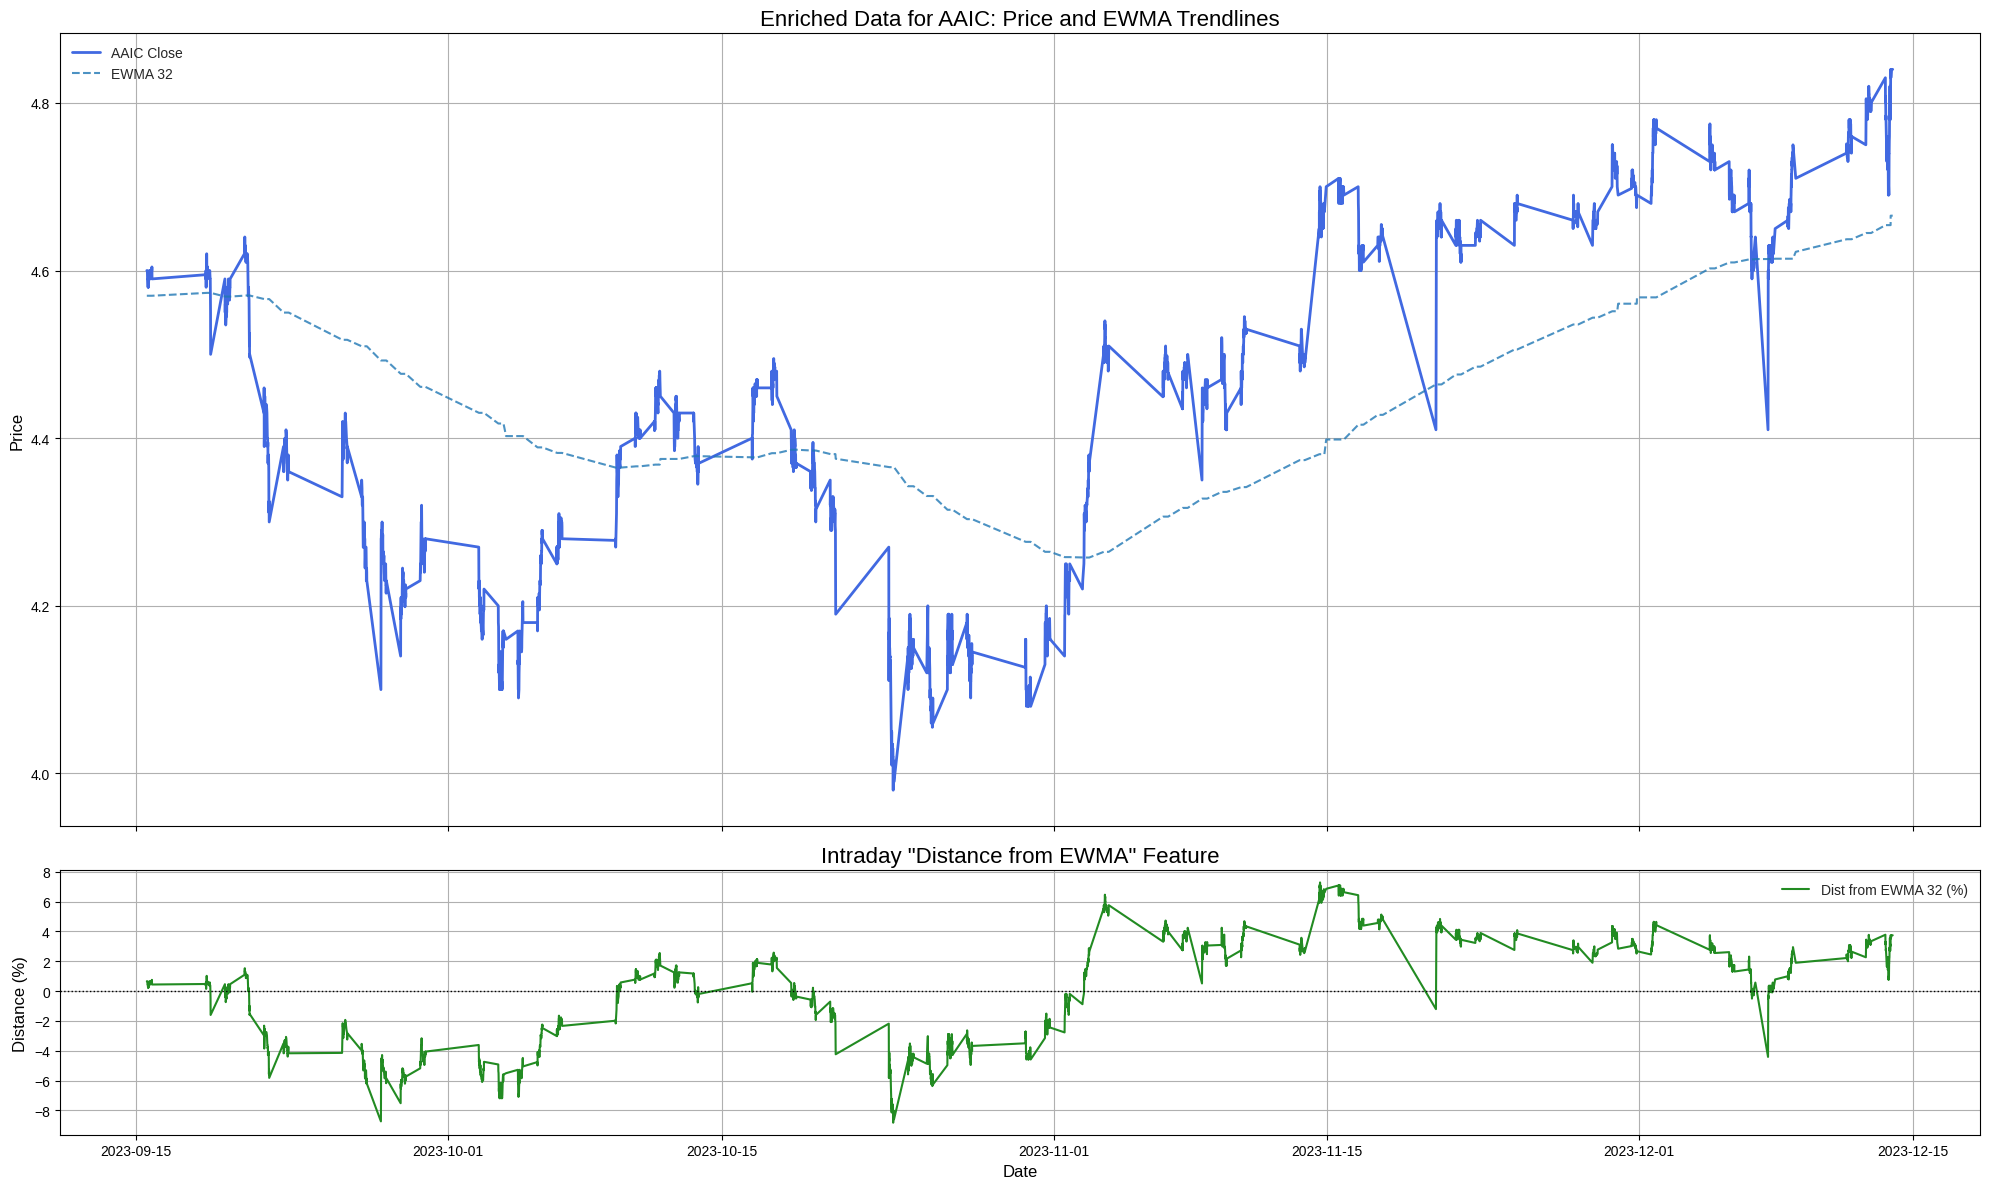

In [1]:
import matplotlib.pyplot as plt
from data_manager import DataManager
from pathlib import Path
import pandas as pd

# --- Configuration ---
BASE_DATA_DIR = Path("/home/kyle/data/polygon_cache")
SYMBOL = "AAIC"

# --- Load Enriched Data ---
datamanager = DataManager(BASE_DATA_DIR)
print(f"Loading enriched data for {SYMBOL}...")
# Use enriched=True to load the output of the feature_precalculator
enriched_data = datamanager.get_data(symbol=SYMBOL, enriched=True)

# --- Verification and Analysis ---
if not enriched_data.empty:
    print("Data loaded successfully.")
    print("\nFirst 5 rows of the enriched data:")
    print(enriched_data.head())
    print("\nAvailable columns:")
    print(enriched_data.columns.tolist())
    print("-" * 50)

    # --- Plotting ---
    # Select a smaller time slice for better visualization
    plot_data = enriched_data.last('90D')
    if plot_data.empty:
        print("No data in the last 90 days. Using the full dataset for plotting.")
        plot_data = enriched_data

    # Create a figure with two subplots (sharing the x-axis)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True, 
                                   gridspec_kw={'height_ratios': [3, 1]})
    plt.style.use('seaborn-v0_8-darkgrid')

    # --- Top Plot: Prices and EWMA Trendlines ---
    ax1.set_title(f'Enriched Data for {SYMBOL}: Price and EWMA Trendlines', fontsize=16)
    
    # Plot the main closing price
    ax1.plot(plot_data.index, plot_data['close'], label=f'{SYMBOL} Close', color='royalblue', linewidth=2)

    # Plot a couple of EWMA trendlines to verify they exist
    for period in [32, 200]:
        ewma_col = f'{SYMBOL}_ewma_{period}'
        if ewma_col in plot_data.columns:
            ax1.plot(plot_data.index, plot_data[ewma_col], label=f'EWMA {period}', linestyle='--', alpha=0.8)

    ax1.set_ylabel('Price', fontsize=12)
    ax1.legend()
    ax1.grid(True)

    # --- Bottom Plot: Distance from EWMA ---
    ax2.set_title(f'Intraday "Distance from EWMA" Feature', fontsize=16)
    
    # Plot the distance from the shorter-term EWMA
    dist_col = f'{SYMBOL}_dist_from_ewma_32'
    if dist_col in plot_data.columns:
        ax2.plot(plot_data.index, plot_data[dist_col] * 100, label=f'Dist from EWMA 32 (%)', color='forestgreen')
        # Add a horizontal line at 0 to show when price is at the trendline
        ax2.axhline(0, color='black', linestyle=':', linewidth=1)

    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Distance (%)', fontsize=12)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

else:
    print(f"Could not load enriched data for {SYMBOL}. Please ensure the feature_precalculator.py script has been run successfully for this ticker.")


In [2]:
import matplotlib.pyplot as plt
from data_manager import DataManager
from pretraining_dataset_builder import PretrainingDatasetBuilder # Assumes .py file is in the same directory
from pathlib import Path
from datetime import date
import pandas as pd
import numpy as np

# --- Configuration ---
BASE_DATA_DIR = Path("/home/kyle/data/polygon_cache")
SYMBOL_TO_INSPECT = "AAIC"
DAY_TO_INSPECT = date(2022, 2, 15) # A specific day to ensure reproducibility

# --- 1. Instantiate the Builder ---
datamanager = DataManager(BASE_DATA_DIR)
universe_path = datamanager.get_universe_path()

print("Initializing PretrainingDatasetBuilder...")
builder = PretrainingDatasetBuilder(
    data_manager=datamanager,
    universe_file_path=universe_path,
    window_size=512
)

# --- 2. Generate a Single Sample in Debug Mode ---
print(f"Attempting to generate one sample for {SYMBOL_TO_INSPECT} on {DAY_TO_INSPECT}...")
sample_generator = builder.generate_samples_for_day(
    target_day=DAY_TO_INSPECT,
    tickers_to_process=[SYMBOL_TO_INSPECT] # This is our debug mode
)

# Get the first available sample from that day
try:
    features, targets, context = next(sample_generator)
    print(f"Successfully generated one sample for {context['symbol']} ending at {context['timestamp']}")
except StopIteration:
    print(f"Could not generate a sample for {SYMBOL_TO_INSPECT} on {DAY_TO_INSPECT}.")
    features, context = None, None

# --- 3. Plot Key Features from the Tensor ---
if features is not None:
    print("Plotting key features from the final tensor...")
    
    # Create a dummy time index for the x-axis of the plot
    time_index = pd.to_datetime(np.arange(builder.window_size), unit='m')
    
    # Extract specific features using the builder's feature_map
    main_close_log = features[:, builder.feature_map['main_close']]
    spy_close_log = features[:, builder.feature_map['spy_close']]
    vxx_close_log = features[:, builder.feature_map['vxx_close']]
    
    main_ewma_log = features[:, builder.feature_map['main_ewma_32']]
    spy_ewma_log = features[:, builder.feature_map['spy_ewma_32']]
    
    main_rsi = features[:, builder.feature_map['main_rsi_14']]

    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True, 
                                   gridspec_kw={'height_ratios': [3, 1]})
    plt.style.use('seaborn-v0_8-darkgrid')

    # --- Top Plot: Log-Normalized Prices and EWMAs ---
    ax1.set_title(f'Final Model Input: Log-Normalized Features for One Sample\n(Timestamp: {context["timestamp"]})', fontsize=16)
    ax1.plot(time_index, main_close_log, label=f'{SYMBOL_TO_INSPECT} Close (Log Norm)', color='royalblue', lw=2)
    ax1.plot(time_index, spy_close_log, label='SPY Close (Log Norm)', color='forestgreen', lw=1.5)
    ax1.plot(time_index, vxx_close_log, label='VXX Close (Log Norm)', color='firebrick', lw=1.5)
    ax1.plot(time_index, main_ewma_log, label=f'{SYMBOL_TO_INSPECT} EWMA 32 (Log Norm)', color='royalblue', linestyle='--')
    ax1.plot(time_index, spy_ewma_log, label='SPY EWMA 32 (Log Norm)', color='forestgreen', linestyle='--')
    ax1.axhline(0, color='black', linestyle=':', label='Log Norm Center (0.0)')
    ax1.set_ylabel('Log Value', fontsize=12)
    ax1.legend()
    ax1.grid(True)
    
    # --- Bottom Plot: RSI ---
    ax2.plot(time_index, main_rsi, label=f'{SYMBOL_TO_INSPECT} RSI 14', color='purple')
    ax2.axhline(0.7, color='grey', linestyle=':')
    ax2.axhline(0.3, color='grey', linestyle=':')
    ax2.set_xlabel('Timestep in Window', fontsize=12)
    ax2.set_ylabel('RSI (scaled 0-1)', fontsize=12)
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


2025-07-16 10:55:57,562 - data_manager - INFO - DataManager initialized. Base directory: /home/kyle/data/polygon_cache


Initializing PretrainingDatasetBuilder...


2025-07-16 10:55:57,707 - pretraining_dataset_builder - INFO - Builder initialized with 70 features per timestep.
2025-07-16 10:55:57,707 - pretraining_dataset_builder - INFO - Loading market context data (SPY, VXX) for the first time...
2025-07-16 10:55:57,708 - file_io - INFO - Reading enriched data for SPY from /home/kyle/data/polygon_cache/data/S/SPY/enriched/SPY_enriched.parquet
2025-07-16 10:55:57,730 - file_io - INFO - Reading enriched data for VXX from /home/kyle/data/polygon_cache/data/V/VXX/enriched/VXX_enriched.parquet
2025-07-16 10:55:57,743 - file_io - INFO - Reading enriched data for AAIC from /home/kyle/data/polygon_cache/data/A/AAIC/enriched/AAIC_enriched.parquet


Attempting to generate one sample for AAIC on 2022-02-15...


KeyError: 'spy_close'